# OOI Lab Manual: Lab 7 Primary Production

This notebook demonstrates how to access and process the dataset used in *Lab 7 Primary Production* of the [2021 OOI Lab Manual](https://datalab.marine.rutgers.edu/ooi-lab-exercises/).

By Sage Lichtenwalner, Revised June 24, 2021

In [1]:
# Notebook Setup
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Setup default plot styles
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install git+https://github.com/seagrinch/ooilab.git
import ooilab
ooilab.API_USERNAME = ''
ooilab.API_TOKEN = ''

## 1. Request Data from OOINet

* **Instruments:** 
  * CP04OSSM-RID27-02-FLORTD000 (Chlorophyll-a, Temperature, and Salinity) from the Coastal Pioneer Offshore Surface Mooring
  * CP01CNSM-RID26-07-NUTNRB000 (Nitrate) from the Coastal Pioneer Central Surface Mooring
  * CP03ISSM-SBD11-06-METBKA000 (Shortwave Irradiance) from the Coastal Pioneer Inshore Surface Mooring
* **Time range:** 
  * Four years of data: 2016-01-01 00:00:00 to 2020-01-01 00:00:00


In [3]:
# Data Requests - Telemetered
# ooilab.request_data('CP04OSSM-RID27-02-FLORTD000','telemetered','flort_sample',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# ooilab.request_data('CP01CNSM-RID26-07-NUTNRB000','telemetered','suna_dcl_recovered',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# ooilab.request_data('CP03ISSM-SBD11-06-METBKA000','telemetered','metbk_a_dcl_instrument',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')

# Recovered (could be used once fall 2019 deployments are added, though flort has a gap)
# ooilab.request_data('CP04OSSM-RID27-02-FLORTD000','recovered_host','flort_sample',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# ooilab.request_data('CP01CNSM-RID26-07-NUTNRB000','recovered_inst','suna_dcl_recovered',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# ooilab.request_data('CP03ISSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')

## 2. Load Data Files

In [4]:
url_flort = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20210624T194920110Z-CP04OSSM-RID27-02-FLORTD000-telemetered-flort_sample/catalog.html'
url_nutnr = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20210624T194901114Z-CP01CNSM-RID26-07-NUTNRB000-telemetered-suna_dcl_recovered/catalog.html'
url_metbk = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20210624T194825672Z-CP03ISSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'

In [5]:
# List of data files
flort_files = ooilab.get_filelist(url_flort)
nutnr_files = ooilab.get_filelist(url_nutnr)
metbk_files = ooilab.get_filelist(url_metbk)

In [6]:
def process_one(file_path, selected_variables):
  with xr.open_dataset(file_path) as ds:
    ds = ds.swap_dims({'obs': 'time'}) 
    ds = ds[selected_variables]
    ds.load()
    return ds

In [7]:
%%time
# Load FLORT dataset
datasets = [process_one(p, ['practical_salinity','temp','fluorometric_chlorophyll_a']) for p in flort_files]
data_flort = xr.concat(datasets, 'time')
print('FLORT dataset has %s points' % "{:,}".format(data_flort.time.size))

FLORT dataset has 17,309,314 points
CPU times: user 10.7 s, sys: 10.3 s, total: 21 s
Wall time: 4min 29s


In [8]:
%%time
datasets = [process_one(p, ['salinity_corrected_nitrate']) for p in nutnr_files]
data_nutnr = xr.concat(datasets, 'time')
print('NUTNR dataset has %s points' % "{:,}".format(data_nutnr.time.size))

NUTNR dataset has 440,216 points
CPU times: user 1.28 s, sys: 404 ms, total: 1.68 s
Wall time: 11.3 s


In [9]:
%%time
datasets = [process_one(p, ['longwave_irradiance','shortwave_irradiance',
                           'met_windavg_mag_corr_east','met_windavg_mag_corr_north']) for p in metbk_files]
data_metbk = xr.concat(datasets, 'time')
print('METBK dataset has %s points' % "{:,}".format(data_metbk.time.size))

# Calculate wind speed
data_metbk['wind_speed'] = np.sqrt(data_metbk.met_windavg_mag_corr_north**2 + data_metbk.met_windavg_mag_corr_east**2)

METBK dataset has 1,992,731 points
CPU times: user 4.03 s, sys: 1.81 s, total: 5.84 s
Wall time: 49.7 s


In [10]:
%%time
# Convert to Pandas
df_flort = data_flort[['practical_salinity','temp','fluorometric_chlorophyll_a']].to_dataframe().drop('obs',axis=1)
df_nutnr = data_nutnr[['salinity_corrected_nitrate']].to_dataframe().drop('obs',axis=1)
df_metbk = data_metbk[['wind_speed']].to_dataframe().drop('obs',axis=1)
df_irr = data_metbk[['longwave_irradiance','shortwave_irradiance']].to_dataframe().drop('obs',axis=1)

CPU times: user 290 ms, sys: 271 ms, total: 561 ms
Wall time: 564 ms


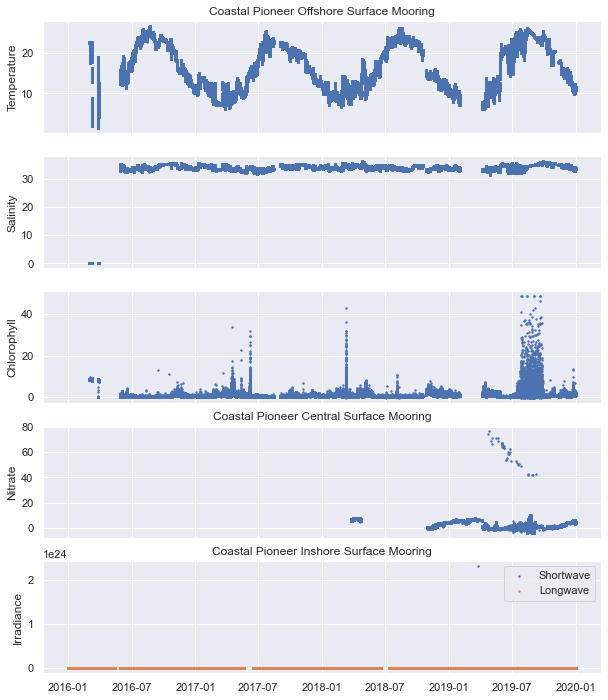

In [11]:
# Plot Temp, Salinty, Chl, DO, Nitrate, Irradiance
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,figsize=(10,12))
ax1.scatter(df_flort.index, df_flort.temp, s=2)
ax2.scatter(df_flort.index, df_flort.practical_salinity, s=2)
ax3.scatter(df_flort.index, df_flort.fluorometric_chlorophyll_a, s=2)
ax4.scatter(df_nutnr.index, df_nutnr.salinity_corrected_nitrate, s=2)
ax5.scatter(df_irr.index, df_irr.shortwave_irradiance, label='Shortwave', s=2)
ax5.scatter(df_irr.index, df_irr.longwave_irradiance, label='Longwave', s=2)
ax5.legend();

ax1.set_xlabel('');
ax2.set_xlabel('');
ax3.set_xlabel('');
ax4.set_xlabel('');

ax1.set_ylabel('Temperature');
ax2.set_ylabel('Salinity');
ax3.set_ylabel('Chlorophyll');
ax4.set_ylabel('Nitrate');
ax5.set_ylabel('Irradiance');

ax1.set_title('Coastal Pioneer Offshore Surface Mooring')
ax4.set_title('Coastal Pioneer Central Surface Mooring')
ax5.set_title('Coastal Pioneer Inshore Surface Mooring')

fig.savefig('production_raw.png');

## 3. Remove Outliers

In [12]:
import numpy as np
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

def clean_data(data,min=0,max=100):
  data = data.where((data>min) & (data<max))
  data = data.where(reject_outliers(data))
  return data


In [13]:
# Remove Outliers
df_flort['practical_salinity'] = clean_data(df_flort['practical_salinity'],30,40)
df_flort['fluorometric_chlorophyll_a'] = clean_data(df_flort['fluorometric_chlorophyll_a'],0,50)
df_nutnr['salinity_corrected_nitrate'] = clean_data(df_nutnr['salinity_corrected_nitrate'],0,40)
df_irr['shortwave_irradiance'] = clean_data(df_irr['shortwave_irradiance'],0,1000)
df_irr['shortwave_irradiance'] = clean_data(df_irr['shortwave_irradiance'],0,1000) #Run again

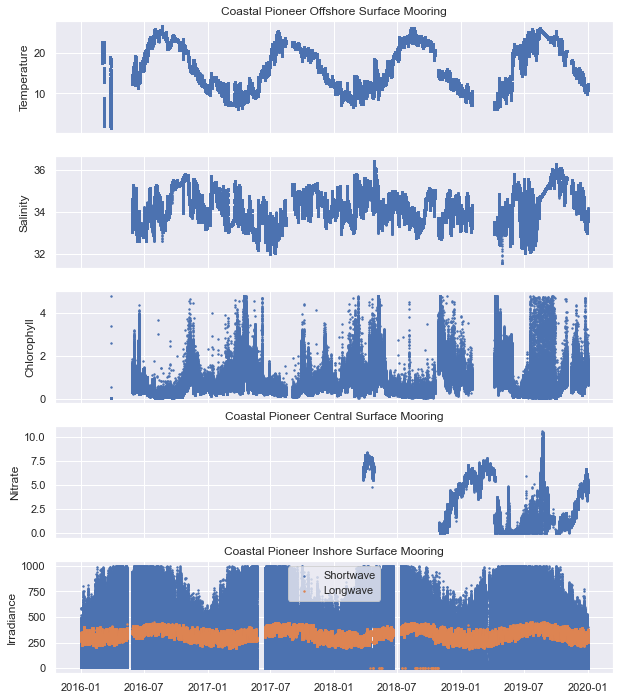

In [14]:
# Plot Temp, Salinty, Chl, DO, Nitrate, Irradiance
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,figsize=(10,12))
ax1.scatter(df_flort.index, df_flort.temp, s=2)
ax2.scatter(df_flort.index, df_flort.practical_salinity, s=2)
ax3.scatter(df_flort.index, df_flort.fluorometric_chlorophyll_a, s=2)
ax4.scatter(df_nutnr.index, df_nutnr.salinity_corrected_nitrate, s=2)
ax5.scatter(df_irr.index, df_irr.shortwave_irradiance, label='Shortwave', s=2)
ax5.scatter(df_irr.index, df_irr.longwave_irradiance, label='Longwave', s=2)
ax5.legend();

ax1.set_xlabel('');
ax2.set_xlabel('');
ax3.set_xlabel('');
ax4.set_xlabel('');

ax1.set_ylabel('Temperature');
ax2.set_ylabel('Salinity');
ax3.set_ylabel('Chlorophyll');
ax4.set_ylabel('Nitrate');
ax5.set_ylabel('Irradiance');

ax1.set_title('Coastal Pioneer Offshore Surface Mooring')
ax4.set_title('Coastal Pioneer Central Surface Mooring')
ax5.set_title('Coastal Pioneer Inshore Surface Mooring')

fig.savefig('production_cleaned.png');

## 4. Average & Merge

In [15]:
df_flort_avg = df_flort.resample('1D').mean()
df_nutnr_avg = df_nutnr.resample('1D').mean()
df_metbk_avg = df_metbk.resample('1D').mean()

# To smooth out the Irradiance data, let's do a 1-week rolling average
df_irr_avg = df_irr.resample('1D').mean().rolling(window=7, min_periods=5, center=True).mean()

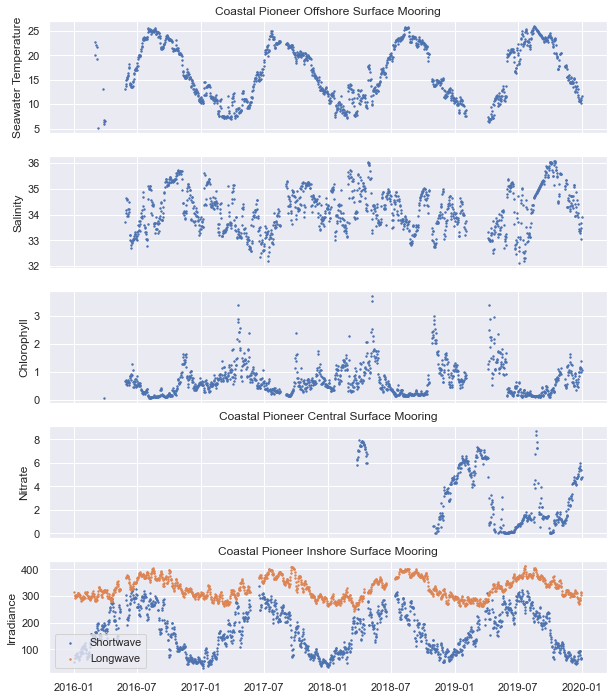

In [16]:
# Plot Temp, Salinty, Chl, DO, Nitrate, Irradiance
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,figsize=(10,12))
ax1.scatter(df_flort_avg.index, df_flort_avg.temp, s=2)
ax2.scatter(df_flort_avg.index, df_flort_avg.practical_salinity, s=2)
ax3.scatter(df_flort_avg.index, df_flort_avg.fluorometric_chlorophyll_a, s=2)
ax4.scatter(df_nutnr_avg.index, df_nutnr_avg.salinity_corrected_nitrate, s=2)
ax5.scatter(df_irr_avg.index, df_irr_avg.shortwave_irradiance, label='Shortwave', s=2)
ax5.scatter(df_irr_avg.index, df_irr_avg.longwave_irradiance, label='Longwave', s=2)
ax5.legend();

ax1.set_xlabel('');
ax2.set_xlabel('');
ax3.set_xlabel('');
ax4.set_xlabel('');

ax1.set_ylabel('Seawater Temperature');
ax2.set_ylabel('Salinity');
ax3.set_ylabel('Chlorophyll');
ax4.set_ylabel('Nitrate');
ax5.set_ylabel('Irradiance');

ax1.set_title('Coastal Pioneer Offshore Surface Mooring')
ax4.set_title('Coastal Pioneer Central Surface Mooring')
ax5.set_title('Coastal Pioneer Inshore Surface Mooring')

fig.savefig('production_1day.png');

## 5. Merge and Export

In [20]:
# Merge datasets
data = df_flort_avg.merge(df_nutnr_avg,on='time',how='outer').merge(df_irr_avg,on='time',how='outer').merge(df_metbk_avg,on='time',how='outer').sort_index()
data.head()

,practical_salinity,temp,fluorometric_chlorophyll_a,salinity_corrected_nitrate,longwave_irradiance,shortwave_irradiance,wind_speed
time,,,,,,,
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,6.118651
2016-01-02,NaN,NaN,NaN,NaN,314.750879,54.576656,8.451065
2016-01-03,NaN,NaN,NaN,NaN,303.349759,67.278474,8.926948
2016-01-04,NaN,NaN,NaN,NaN,298.984974,69.664982,7.489324
2016-01-05,NaN,NaN,NaN,NaN,292.042478,79.520057,9.898300


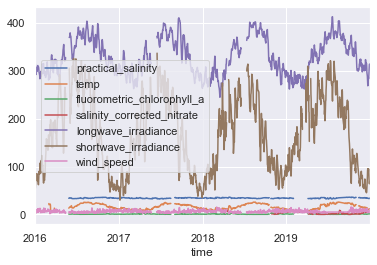

In [21]:
# Quickplot
data.plot();

In [22]:
# Export to CSV
data.to_csv('production.csv')